# Lab 2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import tracemalloc
import sys
from utils import multiply_binet, multiply_strassen
from IPython.display import clear_output

sys.setrecursionlimit(2000)

### Odwracanie macierzy

Odwracanie dużej macierzy zwykle wykonuje się **blokowo**, dzieląc macierz 

$$
A = 
\begin{pmatrix}
A_{11} & A_{12} \\ 
A_{21} & A_{22}
\end{pmatrix}
$$

obliczając uzupełnienie Schura $S = A_{22} - A_{21}A_{11}^{-1}A_{12}$ i następnie składając wynik według wzoru

$$
A^{-1} =
\begin{pmatrix}
A_{11}^{-1} + A_{11}^{-1}A_{12}S^{-1}A_{21}A_{11}^{-1} & -A_{11}^{-1}A_{12}S^{-1} \\
- S^{-1}A_{21}A_{11}^{-1} & S^{-1}
\end{pmatrix},
$$

Cała procedura sprowadza się do wykonywania wielu **mnożeń macierzy** oraz odwracania mniejszych bloków rekursywnie.  
Jeśli w tych miejscach użyjemy klasycznego mnożenia, złożoność całej metody to $ O(n^3) $, bo mnożenia dominują koszt.  
Zastępując mnożenia algorytmem **Strassena**, złożoność spada do $O(n^{\log_2 7}) \approx O(n^{2.807})$.   

In [2]:
def recursive_invert(M, multiply_func, count=None):
    """
    Oblicza odwrotność macierzy M przy użyciu rekurencji blokowej 
    i podanej funkcji mnożenia.
    """
    if count is None:
        count = {'add': 0, 'mul': 0}

    n = M.shape[0]
    if M.shape[1] != n:
        raise ValueError("Macierz musi być kwadratowa.")

    if n == 1:
        val = M[0, 0]
        epsilon = 1e-8  # Ustaw nieco większą tolerancję
    
        if np.abs(val) < epsilon:
            # Rzucamy błąd, bo macierz jest zbyt bliska osobliwości
            raise np.linalg.LinAlgError("Macierz numerycznie osobliwa.")
    
        count['mul'] += 1
        return np.array([[1.0 / val]]), count
    
    # Podział na bloki (działa dla parzystych i nieparzystych n)
    mid = n // 2
    A = M[:mid, :mid]
    B = M[:mid, mid:]
    C = M[mid:, :mid]
    D = M[mid:, mid:]

    # Obliczenia pośrednie
    # A_inv = A^-1
    A_inv, count = recursive_invert(A, multiply_func, count)
    
    # CA_inv = C * A^-1
    CA_inv, count = multiply_func(C, A_inv, count)
    
    # S = D - C * A^-1 * B
    S_part, count = multiply_func(CA_inv, B, count)
    S = np.subtract(D, S_part)
    count['add'] += S.size

    # S_inv = S^-1
    S_inv, count = recursive_invert(S, multiply_func, count)
    
    # H = S^-1
    H = S_inv
    
    # G = -S^-1 * (C * A^-1)
    G_part, count = multiply_func(S_inv, CA_inv, count)
    G = np.negative(G_part) 
    count['mul'] += G.size # zliczanie negacji jako mnożenia przez -1
    
    # F = -(A^-1 * B) * S^-1
    A_inv_B, count = multiply_func(A_inv, B, count)
    F_part, count = multiply_func(A_inv_B, S_inv, count)
    F = np.negative(F_part)
    count['mul'] += F.size # zliczanie negacji jako mnożenia przez -1

    # E = A^-1 - (A^-1 * B * S^-1) * (C * A^-1)
    # E = A_inv - F_part * CA_inv
    E_part, count = multiply_func(F_part, CA_inv, count)
    E = np.subtract(A_inv, E_part)
    count['add'] += E.size # Zliczanie odejmowania

    res = np.empty_like(M)
    res[:mid, :mid] = E
    res[:mid, mid:] = F
    res[mid:, :mid] = G
    res[mid:, mid:] = H
    
    return res, count

### Recursive Gauss & Recursive LU factorization

In [3]:
def solve_lower_recursive(L, b, multiply_func, count=None):
    """
    Rozwiązuje układ L*x = b, gdzie L jest dolnotrójkątna,
    używając rekurencji blokowej.
    """
    if count is None:
        count = {'add': 0, 'mul': 0}
        
    n = L.shape[0]
    if n == 1:
        val = L[0, 0]
        if np.abs(val) < 1e-8:
            raise np.linalg.LinAlgError("Macierz dolnotrójkątna osobliwa.")
        count['mul'] += 1
        return b / val, count

    mid = n // 2
    L11 = L[:mid, :mid]
    L21 = L[mid:, :mid]
    L22 = L[mid:, mid:]
    
    b1 = b[:mid]
    b2 = b[mid:]
    
    # x1 = L11_inv * b1
    x1, count = solve_lower_recursive(L11, b1, multiply_func, count)
    
    # x2 = L22_inv * (b2 - L21 * x1)
    b2_mod_part, count = multiply_func(L21, x1, count)
    b2_mod = np.subtract(b2, b2_mod_part)
    count['add'] += b2_mod.size
    
    x2, count = solve_lower_recursive(L22, b2_mod, multiply_func, count)
    
    x = np.vstack((x1, x2))
    return x, count

def solve_upper_recursive(U, b, multiply_func, count=None):
    """
    Rozwiązuje układ U*x = b, gdzie U jest górnotrójkątna,
    używając rekurencji blokowej.
    """
    if count is None:
        count = {'add': 0, 'mul': 0}
        
    n = U.shape[0]
    if n == 1:
        val = U[0, 0]
        if np.abs(val) < 1e-8:
            raise np.linalg.LinAlgError("Macierz górnotrójkątna osobliwa.")
        count['mul'] += 1
        return b / val, count

    mid = n // 2
    U11 = U[:mid, :mid]
    U12 = U[:mid, mid:]
    U22 = U[mid:, mid:]
    
    b1 = b[:mid]
    b2 = b[mid:]
    
    # x2 = U22_inv * b2
    x2, count = solve_upper_recursive(U22, b2, multiply_func, count)
    
    # x1 = U11_inv * (b1 - U12 * x2)
    b1_mod_part, count = multiply_func(U12, x2, count)
    b1_mod = np.subtract(b1, b1_mod_part)
    count['add'] += b1_mod.size
    
    x1, count = solve_upper_recursive(U11, b1_mod, multiply_func, count)
    
    x = np.vstack((x1, x2))
    return x, count


def recursive_lu(A, multiply_func, count=None):
    """
    Oblicza faktoryzację LU (metoda Doolittle) i wyznacznik
    przy użyciu rekurencji blokowej. Zwraca (L, U, det, count).
    """
    if count is None:
        count = {'add': 0, 'mul': 0}
        
    n = A.shape[0]
    if A.shape[1] != n:
        raise ValueError("Macierz musi być kwadratowa.")
        
    if n == 1:
        val = A[0, 0]
        if np.abs(val) < 1e-8:
            raise np.linalg.LinAlgError("Element na przekątnej zbyt bliski zera.")
        L = np.array([[1.0]])
        U = A
        det = val
        return L, U, det, count
    
    mid = n // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]
    
    # L11, U11, det1 = lu(A11)
    L11, U11, det1, count = recursive_lu(A11, multiply_func, count)
    
    # U12 = L11_inv * A12
    U12, count = solve_lower_recursive(L11, A12, multiply_func, count)
    
    # L21 = A21 * U11_inv
    L21, count = solve_upper_recursive(U11.T, A21.T, multiply_func, count)
    L21 = L21.T
    
    # S = A22 - L21 * U12 (Dopełnienie Schura)
    S_part, count = multiply_func(L21, U12, count)
    S = np.subtract(A22, S_part)
    count['add'] += S.size
    
    # L22, U22, det2 = lu(S)
    L22, U22, det2, count = recursive_lu(S, multiply_func, count)
    
    # Wyznacznik
    det = det1 * det2
    count['mul'] += 1
    
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    
    L[:mid, :mid] = L11
    L[mid:, :mid] = L21
    L[mid:, mid:] = L22
    
    U[:mid, :mid] = U11
    U[:mid, mid:] = U12
    U[mid:, mid:] = U22
    
    return L, U, det, count

def recursive_gauss_solve(A, b, multiply_func, count=None):
    """
    Rozwiązuje układ A*x = b przez rekurencyjną eliminację Gaussa
    (korzystając z rekurencyjnej faktoryzacji LU).
    Zwraca (x, count).
    """
    if count is None:
        count = {'add': 0, 'mul': 0}
        
    # Faktoryzacja A = LU
    L, U, det, count = recursive_lu(A, multiply_func, count)
    
    # Rozwiąż L*c = b (Forward substitution)
    c, count = solve_lower_recursive(L, b, multiply_func, count)
    
    # Rozwiąż U*x = c (Backward substitution)
    x, count = solve_upper_recursive(U, c, multiply_func, count)
    
    return x, count

### Comparision of runtime

In [4]:
matrices = np.load("matrices.npz") # if doesn't exist: run test_generator.py

SIZE = 500

In [5]:
results_invert_binet = []
counts_invert_binet = []
times_invert_binet = []
memory_invert_binet = []

results_lu_binet = []
counts_lu_binet = []
times_lu_binet = []
memory_lu_binet = []

results_gauss_binet = []
counts_gauss_binet = []
times_gauss_binet = []
memory_gauss_binet = []

for n in range(1, SIZE + 1):
    clear_output(wait=True)
    print(f"Binet: Rozmiar = {n}/{SIZE}")
    
    M = matrices[f"A_{n}"]
    # Dodajemy dominującą przekątną, aby uniknąć macierzy osobliwych
    M = M + np.eye(n) * (10 * n) 
    # Wektor b dla Gaussa
    b = np.random.rand(n, 1) * 0.99999999 + 0.00000001
    
    # --- Test 1: Inwersja ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        res, cnt = recursive_invert(M, multiply_binet) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_invert_binet.append(res)
        counts_invert_binet.append(cnt)
        times_invert_binet.append(time_)
        memory_invert_binet.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (Invert) singular. Skipping.")
        tracemalloc.stop()
        # Dodajemy puste wartości, aby utrzymać synchronizację indeksów
        results_invert_binet.append(None) 
        counts_invert_binet.append({'add': 0, 'mul': 0})
        times_invert_binet.append(0)
        memory_invert_binet.append(0)
        
    # --- Test 2: LU ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        res_lu, cnt_lu = recursive_gauss_solve(M, b, multiply_binet) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_gauss_binet.append(res_lu)
        counts_gauss_binet.append(cnt_lu)
        times_gauss_binet.append(time_)
        memory_gauss_binet.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (Gauss) singular. Skipping.")
        tracemalloc.stop()
        results_gauss_binet.append(None)
        counts_gauss_binet.append({'add': 0, 'mul': 0})
        times_gauss_binet.append(0)
        memory_gauss_binet.append(0)
        
    # --- Test 3: Gauss ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        L, U, det, cnt_lu = recursive_lu(M, multiply_binet) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_lu_binet.append((L, U, det))
        counts_lu_binet.append(cnt_lu)
        times_lu_binet.append(time_)
        memory_lu_binet.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (LU) singular. Skipping.")
        tracemalloc.stop()
        results_lu_binet.append(None)
        counts_lu_binet.append({'add': 0, 'mul': 0})
        times_lu_binet.append(0)
        memory_lu_binet.append(0)

Binet: Rozmiar = 500/500


In [6]:
results_invert_strassen = []
counts_invert_strassen = []
times_invert_strassen = []
memory_invert_strassen = []

results_lu_strassen = []
counts_lu_strassen = []
times_lu_strassen = []
memory_lu_strassen = []

results_gauss_strassen = []
counts_gauss_strassen = []
times_gauss_strassen = []
memory_gauss_strassen = []

for n in range(1, SIZE + 1):
    clear_output(wait=True)
    print(f"Strassen: Rozmiar = {n}/{SIZE}")
    
    M = matrices[f"A_{n}"]
    M = M + np.eye(n) * (10 * n) 
    b = np.random.rand(n, 1) * 0.99999999 + 0.00000001
    
    # --- Test 1: Inwersja ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        res, cnt = recursive_invert(M, multiply_strassen) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_invert_strassen.append(res)
        counts_invert_strassen.append(cnt)
        times_invert_strassen.append(time_)
        memory_invert_strassen.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (Invert) singular. Skipping.")
        tracemalloc.stop()
        results_invert_strassen.append(None)
        counts_invert_strassen.append({'add': 0, 'mul': 0})
        times_invert_strassen.append(0)
        memory_invert_strassen.append(0)
        
    # --- Test 2: LU ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        res_lu, cnt_lu = recursive_gauss_solve(M, b, multiply_strassen) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_gauss_strassen.append(res_lu)
        counts_gauss_strassen.append(cnt_lu)
        times_gauss_strassen.append(time_)
        memory_gauss_strassen.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (Gauss) singular. Skipping.")
        tracemalloc.stop()
        results_gauss_strassen.append(None)
        counts_gauss_strassen.append({'add': 0, 'mul': 0})
        times_gauss_strassen.append(0)
        memory_gauss_strassen.append(0)
        
    # --- Test 3: Gauss ---
    try:
        tracemalloc.start()
        start_memory, start_peak = tracemalloc.get_traced_memory()
        start = time.perf_counter()
        
        L, U, det, cnt_lu = recursive_lu(M, multiply_strassen) 
        
        time_ = time.perf_counter() - start
        current_memory, peak_memory = tracemalloc.get_traced_memory()
        mem = peak_memory - start_peak
        tracemalloc.stop()
        
        results_lu_strassen.append((L, U, det))
        counts_lu_strassen.append(cnt_lu)
        times_lu_strassen.append(time_)
        memory_lu_strassen.append(mem)

    except np.linalg.LinAlgError:
        print(f"Warning: Matrix A_{n} (LU) singular. Skipping.")
        tracemalloc.stop()
        results_lu_strassen.append(None)
        counts_lu_strassen.append({'add': 0, 'mul': 0})
        times_lu_strassen.append(0)
        memory_lu_strassen.append(0)

Strassen: Rozmiar = 500/500


In [12]:
# Przygotowanie danych i limitów osi Y dla siatki 3x3
x = list(range(1, SIZE + 1))
x_mem = x[1:]

# --- Obliczanie FLOPs ---
flops_invert_binet = [y["mul"] + y["add"] for y in counts_invert_binet]
flops_lu_binet = [y["mul"] + y["add"] for y in counts_lu_binet]
flops_gauss_binet = [y["mul"] + y["add"] for y in counts_gauss_binet]

flops_invert_strassen = [y["mul"] + y["add"] for y in counts_invert_strassen]
flops_lu_strassen = [y["mul"] + y["add"] for y in counts_lu_strassen]
flops_gauss_strassen = [y["mul"] + y["add"] for y in counts_gauss_strassen]

# --- Obliczanie Wydajności (FLOPs/s) ---
performance_invert_binet = [(flops_invert_binet[i] / times_invert_binet[i]) if times_invert_binet[i] > 0 else 0 for i in range(len(x))]
performance_lu_binet = [(flops_lu_binet[i] / times_lu_binet[i]) if times_lu_binet[i] > 0 else 0 for i in range(len(x))]
performance_gauss_binet = [(flops_gauss_binet[i] / times_gauss_binet[i]) if times_gauss_binet[i] > 0 else 0 for i in range(len(x))]

performance_invert_strassen = [(flops_invert_strassen[i] / times_invert_strassen[i]) if times_invert_strassen[i] > 0 else 0 for i in range(len(x))]
performance_lu_strassen = [(flops_lu_strassen[i] / times_lu_strassen[i]) if times_lu_strassen[i] > 0 else 0 for i in range(len(x))]
performance_gauss_strassen = [(flops_gauss_strassen[i] / times_gauss_strassen[i]) if times_gauss_strassen[i] > 0 else 0 for i in range(len(x))]

# --- Obliczanie Pamięci (z pominięciem n=1) ---
mem_invert_binet = memory_invert_binet[1:]
mem_lu_binet = memory_lu_binet[1:]
mem_gauss_binet = memory_gauss_binet[1:]
mem_invert_strassen = memory_invert_strassen[1:]
mem_lu_strassen = memory_lu_strassen[1:]
mem_gauss_strassen = memory_gauss_strassen[1:]


# --- Funkcja pomocnicza do limitów Y (dla każdego wiersza wykresów) ---
def get_y_lim(data_binet, data_strassen):
    y_max = max(max(data_binet) if data_binet else 0, max(data_strassen) if data_strassen else 0)
    return [0, y_max * 1.05] if y_max > 0 else [0, 1]

# Limity dla Czasu (per algorytm)
y_lim_time_invert = get_y_lim(times_invert_binet, times_invert_strassen)
y_lim_time_lu = get_y_lim(times_lu_binet, times_lu_strassen)
y_lim_time_gauss = get_y_lim(times_gauss_binet, times_gauss_strassen)

# Limity dla FLOPs (per algorytm)
y_lim_flops_invert = get_y_lim(flops_invert_binet, flops_invert_strassen)
y_lim_flops_lu = get_y_lim(flops_lu_binet, flops_lu_strassen)
y_lim_flops_gauss = get_y_lim(flops_gauss_binet, flops_gauss_strassen)

# Limity dla Pamięci (per algorytm)
y_lim_mem_invert = get_y_lim(mem_invert_binet, mem_invert_strassen)
y_lim_mem_lu = get_y_lim(mem_lu_binet, mem_lu_strassen)
y_lim_mem_gauss = get_y_lim(mem_gauss_binet, mem_gauss_strassen)

# Limity dla Wydajności (per algorytm)
y_lim_perf_invert = get_y_lim(performance_invert_binet, performance_invert_strassen)
y_lim_perf_lu = get_y_lim(performance_lu_binet, performance_lu_strassen)
y_lim_perf_gauss = get_y_lim(performance_gauss_binet, performance_gauss_strassen)

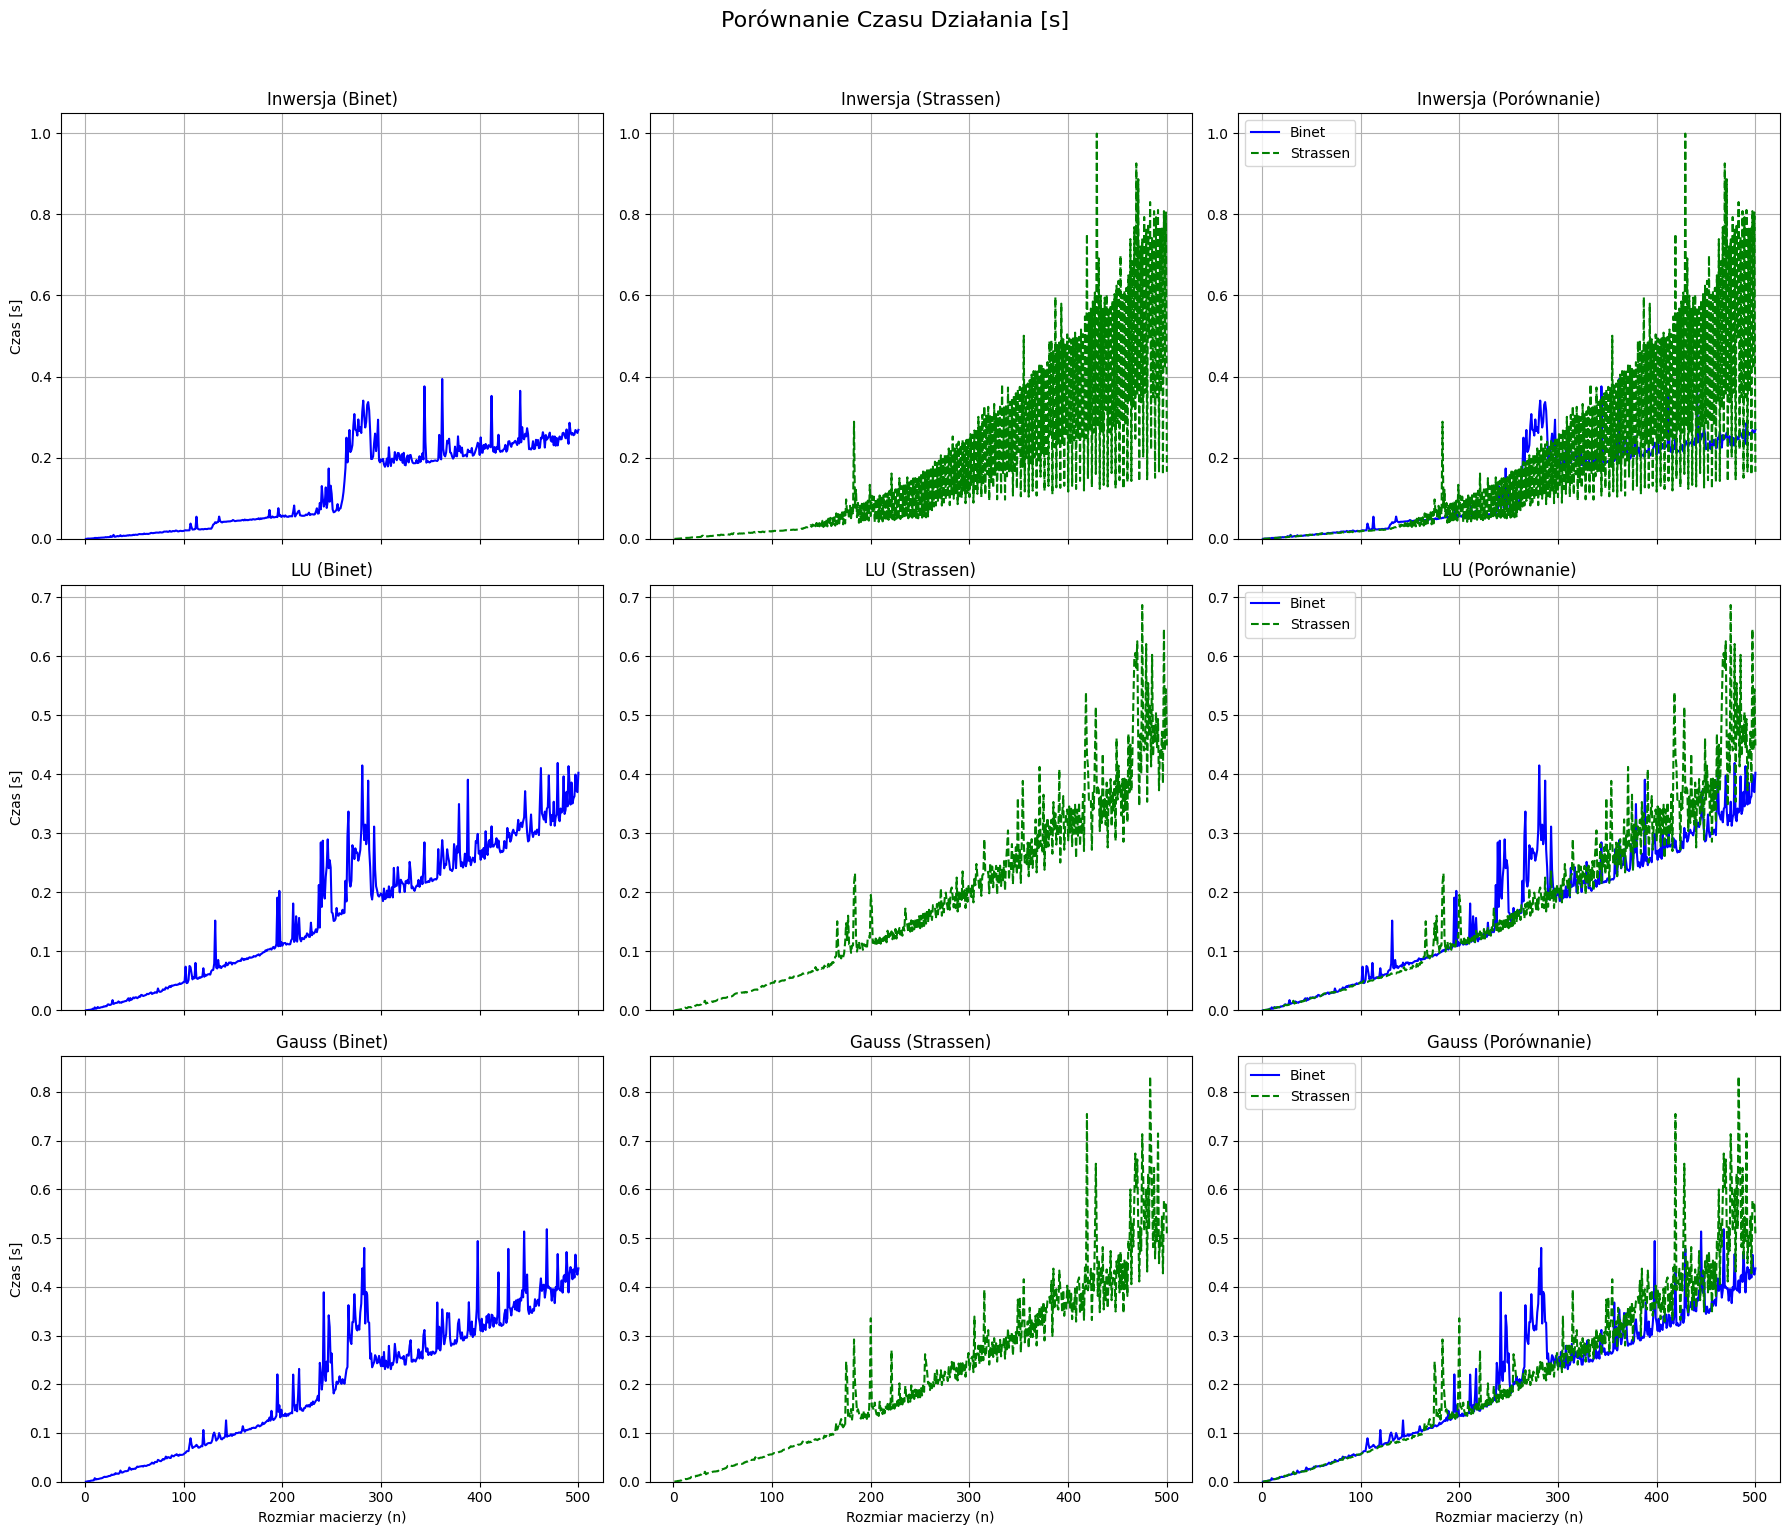

In [13]:
# Wykresy Czasu Działania (Siatka 3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True)
fig.suptitle('Porównanie Czasu Działania [s]', fontsize=16, y=1.02)

# --- Wiersz 1: Inwersja ---
axes[0, 0].plot(x, times_invert_binet, label='Inwersja (Binet)', color='blue')
axes[0, 0].set_title('Inwersja (Binet)')
axes[0, 0].set_ylim(y_lim_time_invert)
axes[0, 0].set_ylabel('Czas [s]')
axes[0, 0].grid(True)

axes[0, 1].plot(x, times_invert_strassen, label='Inwersja (Strassen)', color='green', linestyle='--')
axes[0, 1].set_title('Inwersja (Strassen)')
axes[0, 1].set_ylim(y_lim_time_invert)
axes[0, 1].grid(True)

axes[0, 2].plot(x, times_invert_binet, label='Binet', color='blue')
axes[0, 2].plot(x, times_invert_strassen, label='Strassen', color='green', linestyle='--')
axes[0, 2].set_title('Inwersja (Porównanie)')
axes[0, 2].set_ylim(y_lim_time_invert)
axes[0, 2].grid(True)
axes[0, 2].legend()

# --- Wiersz 2: Faktoryzacja LU ---
axes[1, 0].plot(x, times_lu_binet, label='LU (Binet)', color='blue')
axes[1, 0].set_title('LU (Binet)')
axes[1, 0].set_ylim(y_lim_time_lu)
axes[1, 0].set_ylabel('Czas [s]')
axes[1, 0].grid(True)

axes[1, 1].plot(x, times_lu_strassen, label='LU (Strassen)', color='green', linestyle='--')
axes[1, 1].set_title('LU (Strassen)')
axes[1, 1].set_ylim(y_lim_time_lu)
axes[1, 1].grid(True)

axes[1, 2].plot(x, times_lu_binet, label='Binet', color='blue')
axes[1, 2].plot(x, times_lu_strassen, label='Strassen', color='green', linestyle='--')
axes[1, 2].set_title('LU (Porównanie)')
axes[1, 2].set_ylim(y_lim_time_lu)
axes[1, 2].grid(True)
axes[1, 2].legend()

# --- Wiersz 3: Gauss ---
axes[2, 0].plot(x, times_gauss_binet, label='Gauss (Binet)', color='blue')
axes[2, 0].set_title('Gauss (Binet)')
axes[2, 0].set_ylim(y_lim_time_gauss)
axes[2, 0].set_xlabel('Rozmiar macierzy (n)')
axes[2, 0].set_ylabel('Czas [s]')
axes[2, 0].grid(True)

axes[2, 1].plot(x, times_gauss_strassen, label='Gauss (Strassen)', color='green', linestyle='--')
axes[2, 1].set_title('Gauss (Strassen)')
axes[2, 1].set_ylim(y_lim_time_gauss)
axes[2, 1].set_xlabel('Rozmiar macierzy (n)')
axes[2, 1].grid(True)

axes[2, 2].plot(x, times_gauss_binet, label='Binet', color='blue')
axes[2, 2].plot(x, times_gauss_strassen, label='Strassen', color='green', linestyle='--')
axes[2, 2].set_title('Gauss (Porównanie)')
axes[2, 2].set_ylim(y_lim_time_gauss)
axes[2, 2].set_xlabel('Rozmiar macierzy (n)')
axes[2, 2].grid(True)
axes[2, 2].legend()

plt.tight_layout()
plt.show()

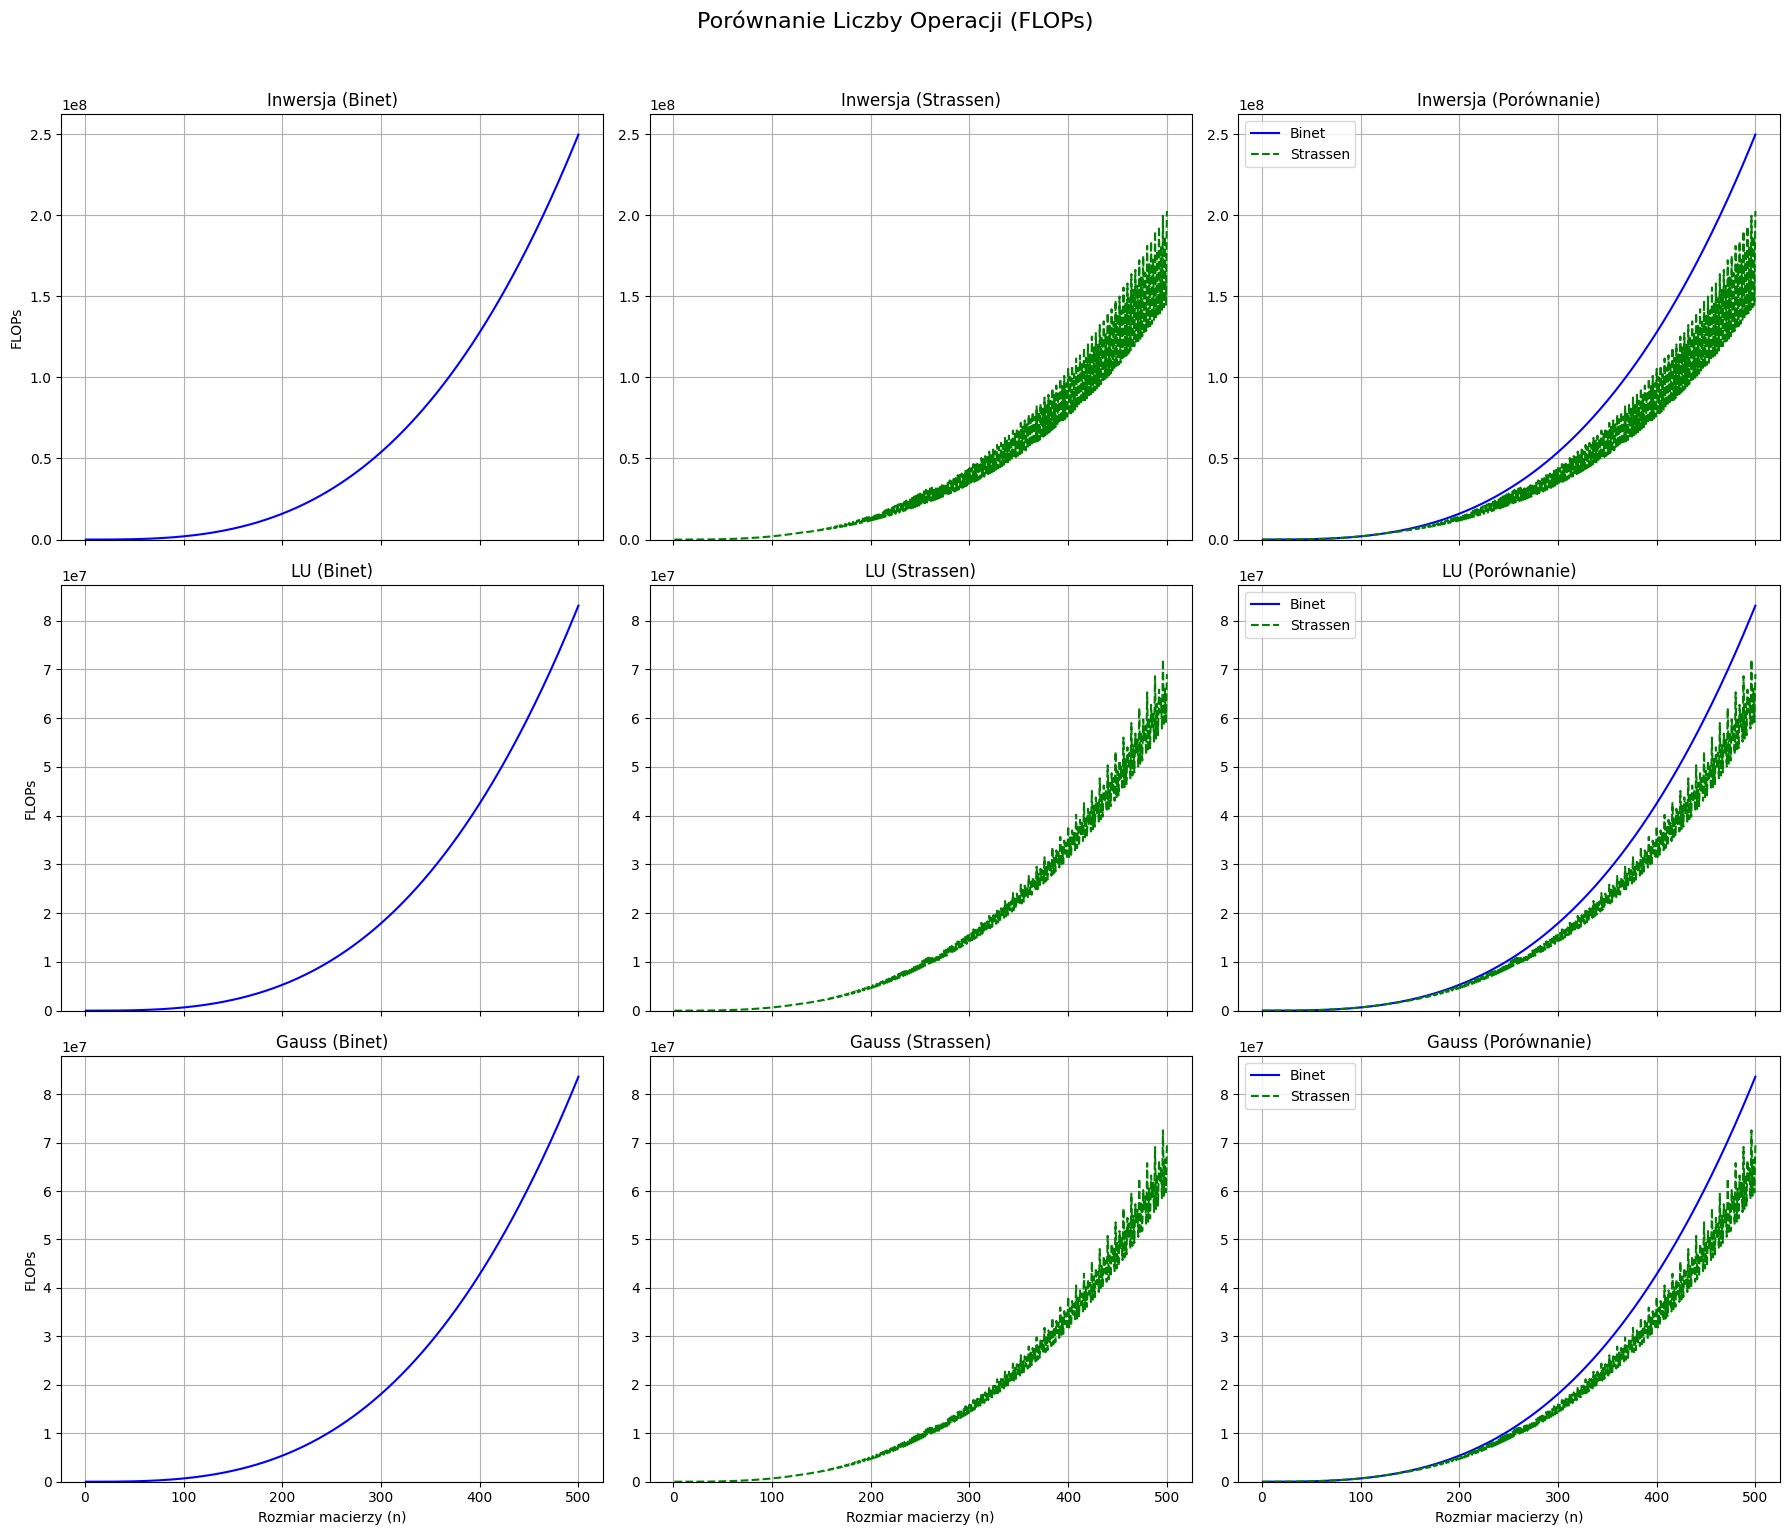

In [14]:
# Wykresy FLOPs (Siatka 3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True)
fig.suptitle('Porównanie Liczby Operacji (FLOPs)', fontsize=16, y=1.02)

# --- Wiersz 1: Inwersja ---
axes[0, 0].plot(x, flops_invert_binet, label='Inwersja (Binet)', color='blue')
axes[0, 0].set_title('Inwersja (Binet)')
axes[0, 0].set_ylim(y_lim_flops_invert)
axes[0, 0].set_ylabel('FLOPs')
axes[0, 0].grid(True)

axes[0, 1].plot(x, flops_invert_strassen, label='Inwersja (Strassen)', color='green', linestyle='--')
axes[0, 1].set_title('Inwersja (Strassen)')
axes[0, 1].set_ylim(y_lim_flops_invert)
axes[0, 1].grid(True)

axes[0, 2].plot(x, flops_invert_binet, label='Binet', color='blue')
axes[0, 2].plot(x, flops_invert_strassen, label='Strassen', color='green', linestyle='--')
axes[0, 2].set_title('Inwersja (Porównanie)')
axes[0, 2].set_ylim(y_lim_flops_invert)
axes[0, 2].grid(True)
axes[0, 2].legend()

# --- Wiersz 2: Faktoryzacja LU ---
axes[1, 0].plot(x, flops_lu_binet, label='LU (Binet)', color='blue')
axes[1, 0].set_title('LU (Binet)')
axes[1, 0].set_ylim(y_lim_flops_lu)
axes[1, 0].set_ylabel('FLOPs')
axes[1, 0].grid(True)

axes[1, 1].plot(x, flops_lu_strassen, label='LU (Strassen)', color='green', linestyle='--')
axes[1, 1].set_title('LU (Strassen)')
axes[1, 1].set_ylim(y_lim_flops_lu)
axes[1, 1].grid(True)

axes[1, 2].plot(x, flops_lu_binet, label='Binet', color='blue')
axes[1, 2].plot(x, flops_lu_strassen, label='Strassen', color='green', linestyle='--')
axes[1, 2].set_title('LU (Porównanie)')
axes[1, 2].set_ylim(y_lim_flops_lu)
axes[1, 2].grid(True)
axes[1, 2].legend()

# --- Wiersz 3: Gauss ---
axes[2, 0].plot(x, flops_gauss_binet, label='Gauss (Binet)', color='blue')
axes[2, 0].set_title('Gauss (Binet)')
axes[2, 0].set_ylim(y_lim_flops_gauss)
axes[2, 0].set_xlabel('Rozmiar macierzy (n)')
axes[2, 0].set_ylabel('FLOPs')
axes[2, 0].grid(True)

axes[2, 1].plot(x, flops_gauss_strassen, label='Gauss (Strassen)', color='green', linestyle='--')
axes[2, 1].set_title('Gauss (Strassen)')
axes[2, 1].set_ylim(y_lim_flops_gauss)
axes[2, 1].set_xlabel('Rozmiar macierzy (n)')
axes[2, 1].grid(True)

axes[2, 2].plot(x, flops_gauss_binet, label='Binet', color='blue')
axes[2, 2].plot(x, flops_gauss_strassen, label='Strassen', color='green', linestyle='--')
axes[2, 2].set_title('Gauss (Porównanie)')
axes[2, 2].set_ylim(y_lim_flops_gauss)
axes[2, 2].set_xlabel('Rozmiar macierzy (n)')
axes[2, 2].grid(True)
axes[2, 2].legend()

plt.tight_layout()
plt.show()

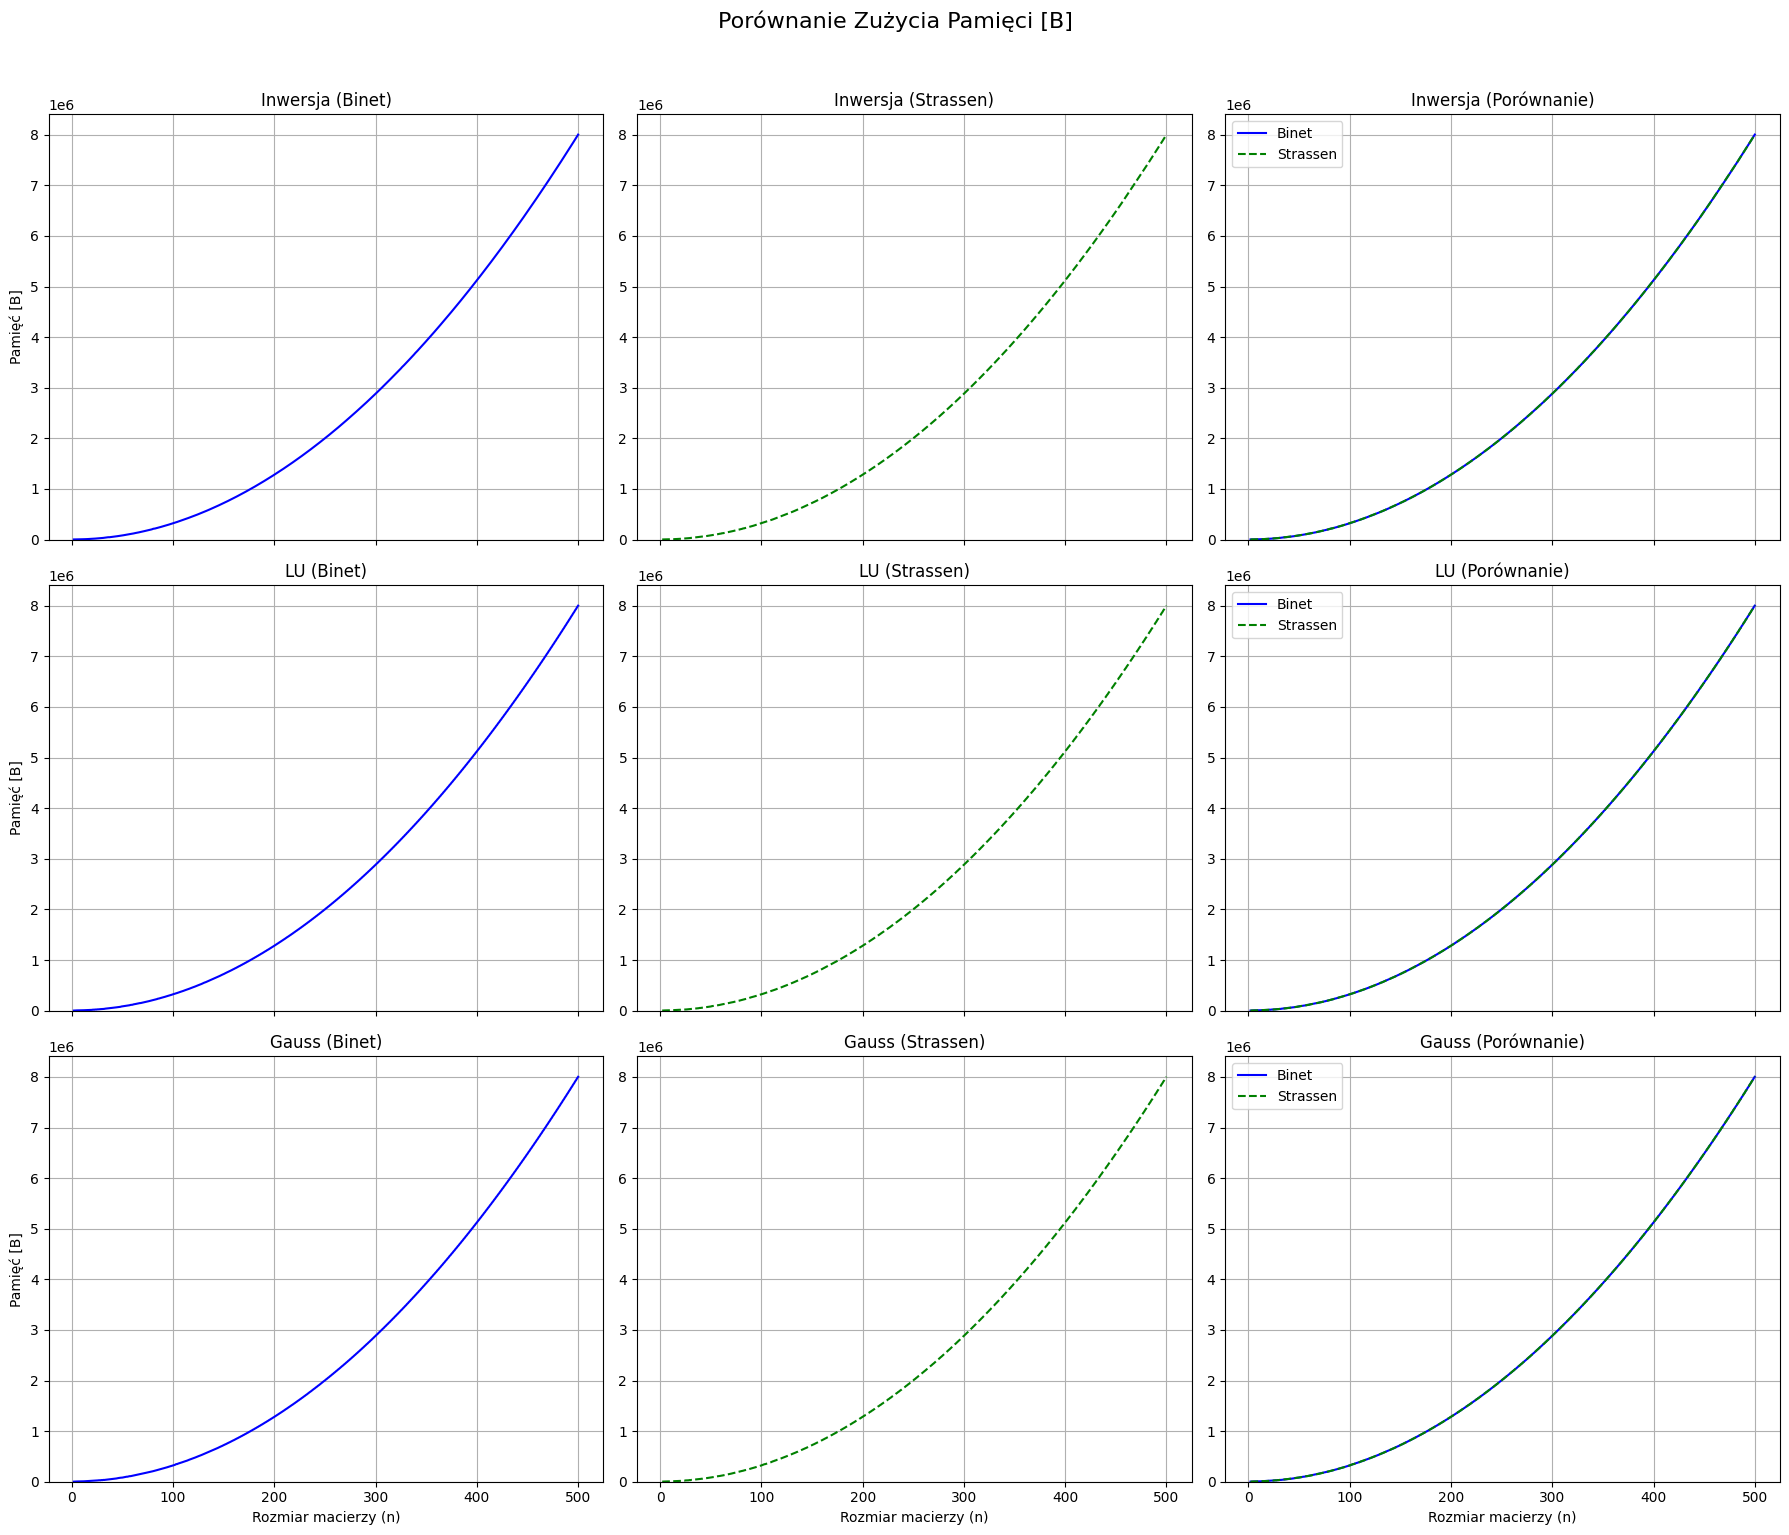

In [15]:
# Wykresy Zużycia Pamięci (Siatka 3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True)
fig.suptitle('Porównanie Zużycia Pamięci [B]', fontsize=16, y=1.02)

# --- Wiersz 1: Inwersja ---
axes[0, 0].plot(x_mem, mem_invert_binet, label='Inwersja (Binet)', color='blue')
axes[0, 0].set_title('Inwersja (Binet)')
axes[0, 0].set_ylim(y_lim_mem_invert)
axes[0, 0].set_ylabel('Pamięć [B]')
axes[0, 0].grid(True)

axes[0, 1].plot(x_mem, mem_invert_strassen, label='Inwersja (Strassen)', color='green', linestyle='--')
axes[0, 1].set_title('Inwersja (Strassen)')
axes[0, 1].set_ylim(y_lim_mem_invert)
axes[0, 1].grid(True)

axes[0, 2].plot(x_mem, mem_invert_binet, label='Binet', color='blue')
axes[0, 2].plot(x_mem, mem_invert_strassen, label='Strassen', color='green', linestyle='--')
axes[0, 2].set_title('Inwersja (Porównanie)')
axes[0, 2].set_ylim(y_lim_mem_invert)
axes[0, 2].grid(True)
axes[0, 2].legend()

# --- Wiersz 2: Faktoryzacja LU ---
axes[1, 0].plot(x_mem, mem_lu_binet, label='LU (Binet)', color='blue')
axes[1, 0].set_title('LU (Binet)')
axes[1, 0].set_ylim(y_lim_mem_lu)
axes[1, 0].set_ylabel('Pamięć [B]')
axes[1, 0].grid(True)

axes[1, 1].plot(x_mem, mem_lu_strassen, label='LU (Strassen)', color='green', linestyle='--')
axes[1, 1].set_title('LU (Strassen)')
axes[1, 1].set_ylim(y_lim_mem_lu)
axes[1, 1].grid(True)

axes[1, 2].plot(x_mem, mem_lu_binet, label='Binet', color='blue')
axes[1, 2].plot(x_mem, mem_lu_strassen, label='Strassen', color='green', linestyle='--')
axes[1, 2].set_title('LU (Porównanie)')
axes[1, 2].set_ylim(y_lim_mem_lu)
axes[1, 2].grid(True)
axes[1, 2].legend()

# --- Wiersz 3: Gauss ---
axes[2, 0].plot(x_mem, mem_gauss_binet, label='Gauss (Binet)', color='blue')
axes[2, 0].set_title('Gauss (Binet)')
axes[2, 0].set_ylim(y_lim_mem_gauss)
axes[2, 0].set_xlabel('Rozmiar macierzy (n)')
axes[2, 0].set_ylabel('Pamięć [B]')
axes[2, 0].grid(True)

axes[2, 1].plot(x_mem, mem_gauss_strassen, label='Gauss (Strassen)', color='green', linestyle='--')
axes[2, 1].set_title('Gauss (Strassen)')
axes[2, 1].set_ylim(y_lim_mem_gauss)
axes[2, 1].set_xlabel('Rozmiar macierzy (n)')
axes[2, 1].grid(True)

axes[2, 2].plot(x_mem, mem_gauss_binet, label='Binet', color='blue')
axes[2, 2].plot(x_mem, mem_gauss_strassen, label='Strassen', color='green', linestyle='--')
axes[2, 2].set_title('Gauss (Porównanie)')
axes[2, 2].set_ylim(y_lim_mem_gauss)
axes[2, 2].set_xlabel('Rozmiar macierzy (n)')
axes[2, 2].grid(True)
axes[2, 2].legend()

plt.tight_layout()
plt.show()

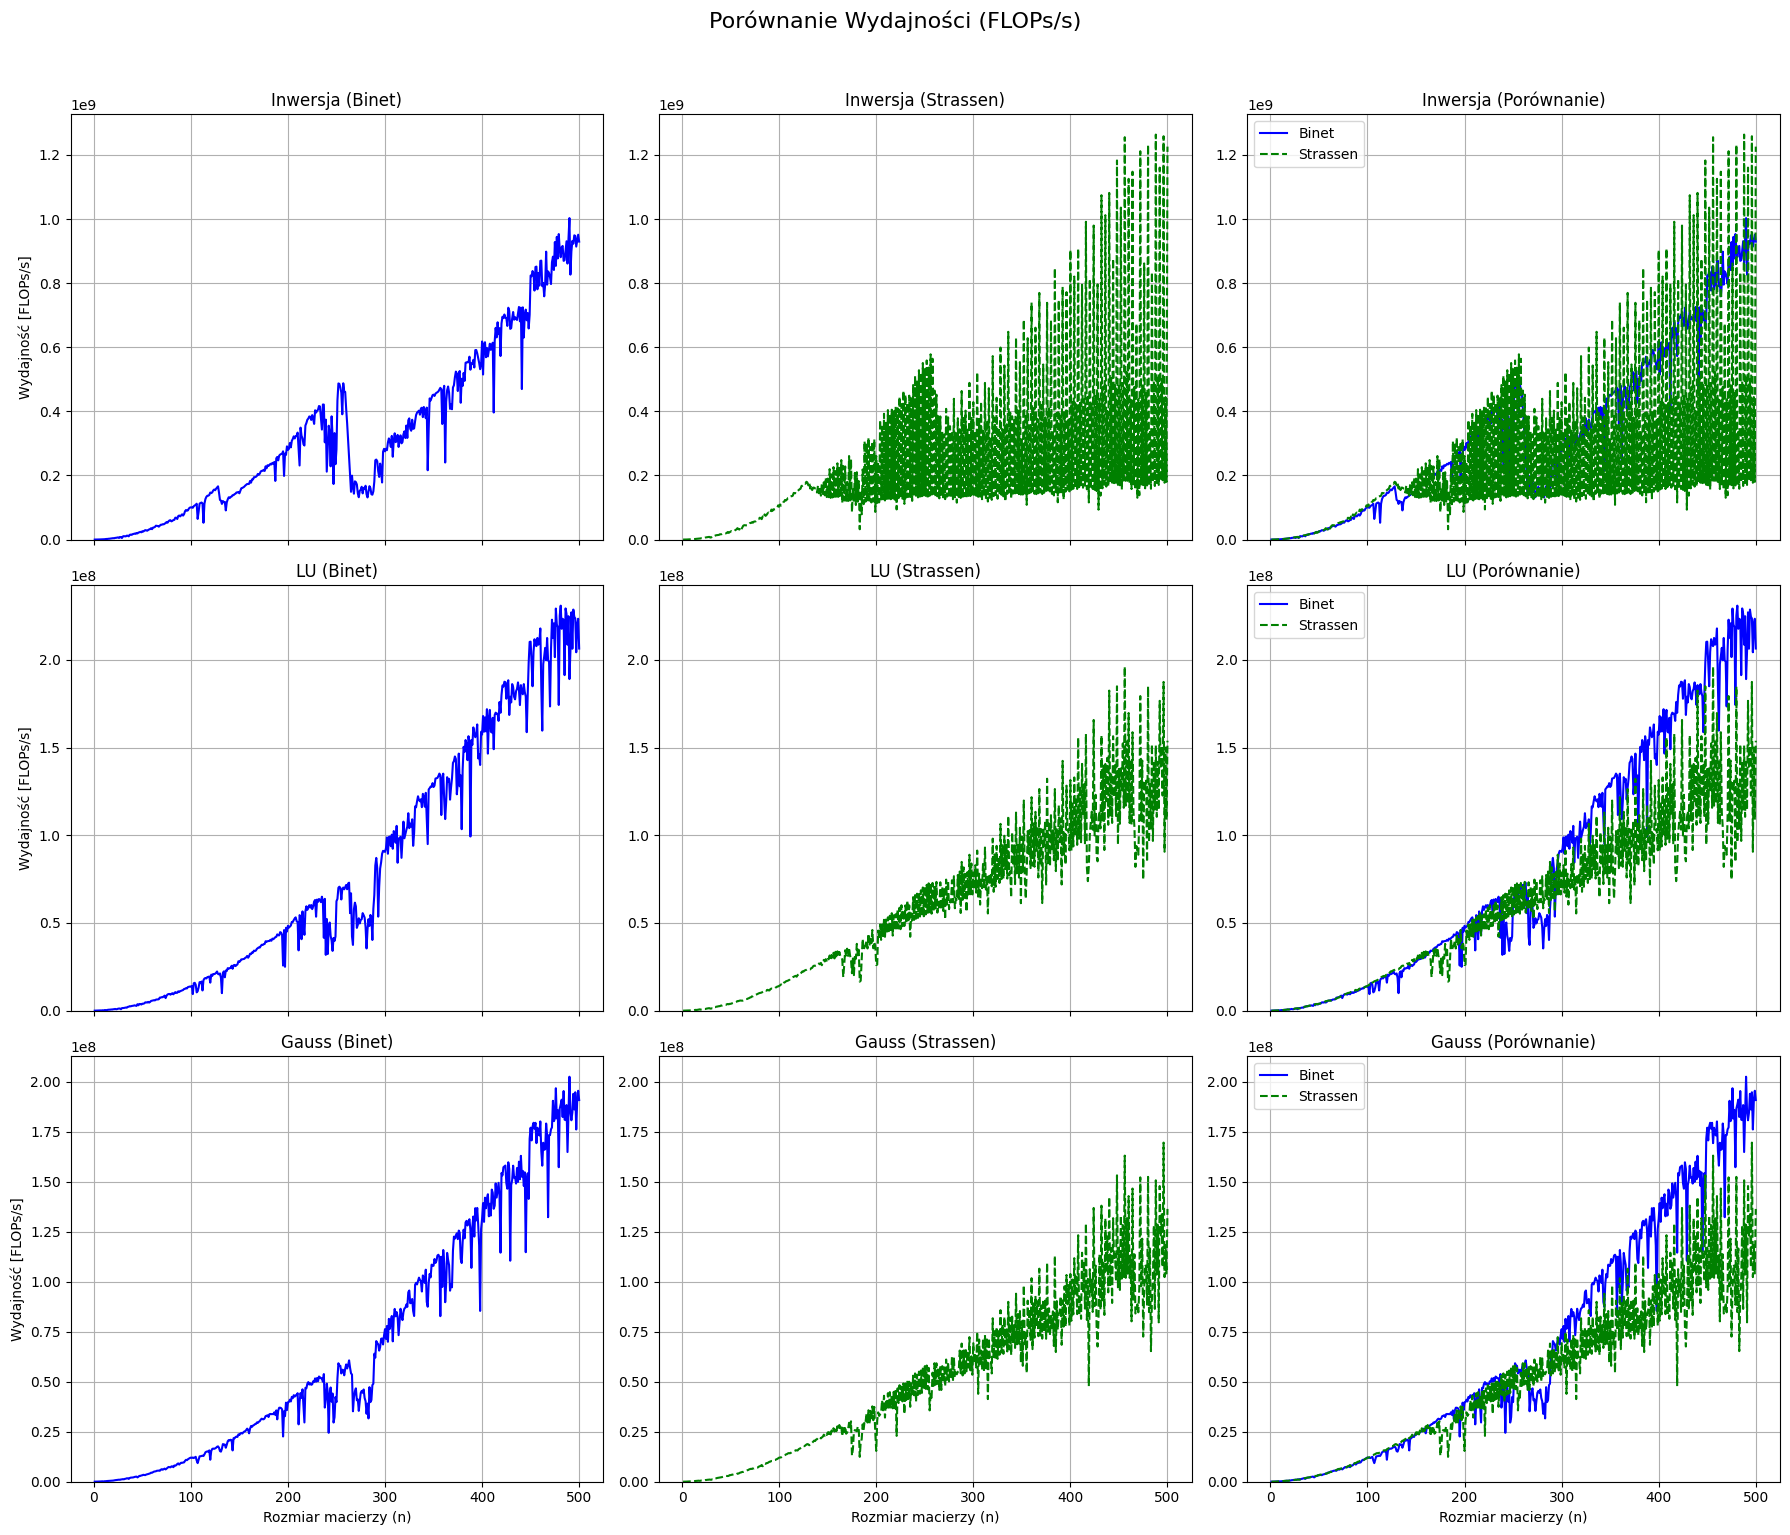

In [16]:
# Wykresy Wydajności (Siatka 3x3)
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True)
fig.suptitle('Porównanie Wydajności (FLOPs/s)', fontsize=16, y=1.02)

# --- Wiersz 1: Inwersja ---
axes[0, 0].plot(x, performance_invert_binet, label='Inwersja (Binet)', color='blue')
axes[0, 0].set_title('Inwersja (Binet)')
axes[0, 0].set_ylim(y_lim_perf_invert)
axes[0, 0].set_ylabel('Wydajność [FLOPs/s]')
axes[0, 0].grid(True)

axes[0, 1].plot(x, performance_invert_strassen, label='Inwersja (Strassen)', color='green', linestyle='--')
axes[0, 1].set_title('Inwersja (Strassen)')
axes[0, 1].set_ylim(y_lim_perf_invert)
axes[0, 1].grid(True)

axes[0, 2].plot(x, performance_invert_binet, label='Binet', color='blue')
axes[0, 2].plot(x, performance_invert_strassen, label='Strassen', color='green', linestyle='--')
axes[0, 2].set_title('Inwersja (Porównanie)')
axes[0, 2].set_ylim(y_lim_perf_invert)
axes[0, 2].grid(True)
axes[0, 2].legend()

# --- Wiersz 2: Faktoryzacja LU ---
axes[1, 0].plot(x, performance_lu_binet, label='LU (Binet)', color='blue')
axes[1, 0].set_title('LU (Binet)')
axes[1, 0].set_ylim(y_lim_perf_lu)
axes[1, 0].set_ylabel('Wydajność [FLOPs/s]')
axes[1, 0].grid(True)

axes[1, 1].plot(x, performance_lu_strassen, label='LU (Strassen)', color='green', linestyle='--')
axes[1, 1].set_title('LU (Strassen)')
axes[1, 1].set_ylim(y_lim_perf_lu)
axes[1, 1].grid(True)

axes[1, 2].plot(x, performance_lu_binet, label='Binet', color='blue')
axes[1, 2].plot(x, performance_lu_strassen, label='Strassen', color='green', linestyle='--')
axes[1, 2].set_title('LU (Porównanie)')
axes[1, 2].set_ylim(y_lim_perf_lu)
axes[1, 2].grid(True)
axes[1, 2].legend()

# --- Wiersz 3: Gauss ---
axes[2, 0].plot(x, performance_gauss_binet, label='Gauss (Binet)', color='blue')
axes[2, 0].set_title('Gauss (Binet)')
axes[2, 0].set_ylim(y_lim_perf_gauss)
axes[2, 0].set_xlabel('Rozmiar macierzy (n)')
axes[2, 0].set_ylabel('Wydajność [FLOPs/s]')
axes[2, 0].grid(True)

axes[2, 1].plot(x, performance_gauss_strassen, label='Gauss (Strassen)', color='green', linestyle='--')
axes[2, 1].set_title('Gauss (Strassen)')
axes[2, 1].set_ylim(y_lim_perf_gauss)
axes[2, 1].set_xlabel('Rozmiar macierzy (n)')
axes[2, 1].grid(True)

axes[2, 2].plot(x, performance_gauss_binet, label='Binet', color='blue')
axes[2, 2].plot(x, performance_gauss_strassen, label='Strassen', color='green', linestyle='--')
axes[2, 2].set_title('Gauss (Porównanie)')
axes[2, 2].set_ylim(y_lim_perf_gauss)
axes[2, 2].set_xlabel('Rozmiar macierzy (n)')
axes[2, 2].grid(True)
axes[2, 2].legend()

plt.tight_layout()
plt.show()